<a href="https://colab.research.google.com/github/AfsaneHeydari/AutoEncoder-based-communication-system-simulation/blob/main/Physical_Layer_Auth_ANN_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

simulation of
A Learning Approach for Physical Layer
Authentication Using Adaptive
Neural Network paper 

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
import math



In [ ]:
class End2EndCommunicationSys():
  
  def __init__(self, signal_size, channel_number ):

    self.communication_sys = None
    self.transmiter = None
    self.receiver = None
    self.channel_layer = None
    self.receivedSignals = None
    self.data = (self.getData(signal_size))

    self.generateModel(signal_size, channel_number)
    

  def generateModel(self,signal_size, channel_number):

    k = np.log2(signal_size)  
    k = int(k)
    R = k/channel_number

    input_signal = Input(shape=(signal_size,))
    encoded = Dense(signal_size, activation='sigmoid')(input_signal) #512 for signal size
    # encoded1 = Dense((signal_size/4), activation='tanh')(encoded) # 128
    encoded2 = Dense(channel_number, activation='linear')(encoded) # 16
    encoded3 = Lambda(lambda x: np.sqrt(channel_number)*K.l2_normalize(x,axis=1))(encoded2) # channel number is 16

    EbNo_train = 5.01187 #  coverted 7 db of EbNo
    self.channel_layer = GaussianNoise(1)(encoded3)

    # decoded = Dense((signal_size/4), activation='tanh')(self.channel_layer)
    # decoded = Dense(signal_size, activation='relu')(self.channel_layer)
    decoded2 = Dense(signal_size, activation='linear')(self.channel_layer)
    self.communication_sys = Model(input_signal, decoded2)
    # adam = Adam(lr=0.00001)
    # adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=50000,
    decay_rate=0.9)

    adam = keras.optimizers.Adam(learning_rate=lr_schedule)
    self.communication_sys.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy','mse'])

# categorical_crossentropy
    data = self.data
    # print('data = {}'.format(data))
    self.communication_sys.fit(data, data,
                epochs=250,
                batch_size=32,
                validation_split=0.1)
    
    self.transmiter = Model(input_signal, encoded3)
    self.receivedSignals = Model(input_signal, self.channel_layer)
  
    encoded_input = Input(shape=(channel_number,))

    # deco = self.communication_sys.layers[-3](encoded_input)
    deco = self.communication_sys.layers[-2](encoded_input)
    deco = self.communication_sys.layers[-1](deco)
    self.receiver = Model(encoded_input, deco)


  def getData(self, signal_size):

    N = 10000
    data = []
  #  l = np.random.randn(signal_size,size=N)
    # print(l)

    for i in range(N):
        temp = np.random.randn(signal_size)
        # print (temp)
        # for i in range(temp.shape[1]):
        #   if temp[0,i]>=0.3:
        #     temp[0,i] = 1
        #   else:
        #     temp[0,i] = 0
      #  temp[0,l[i]] = 1
        
        data.append(temp)

    data = np.array(data)
    return data


  # def getRss(self,received_data):

  #   rss = np.zeros((1,256))
  #   i = 0
  #   for d in received_data:
  #     pr = d*d
  #     rss[0,i]=(10*(math.log(pr)))
  #     i += 1
  #     print(rss[i])

    # pr = pr/len(received_data)

    # return rss


In [ ]:
comSys = End2EndCommunicationSys(512,16)

Epoch 1/250
282/282 [==============================] - 1s 4ms/step - loss: 1.0070 - accuracy: 0.0044 - mse: 1.0070 - val_loss: 0.9804 - val_accuracy: 0.0050 - val_mse: 0.9804
Epoch 2/250
282/282 [==============================] - 1s 4ms/step - loss: 0.9935 - accuracy: 0.0042 - mse: 0.9935 - val_loss: 0.9789 - val_accuracy: 0.0070 - val_mse: 0.9789
Epoch 3/250
282/282 [==============================] - 1s 4ms/step - loss: 0.9921 - accuracy: 0.0047 - mse: 0.9921 - val_loss: 0.9787 - val_accuracy: 0.0110 - val_mse: 0.9787
Epoch 4/250
282/282 [==============================] - 1s 4ms/step - loss: 0.9915 - accuracy: 0.0047 - mse: 0.9915 - val_loss: 0.9777 - val_accuracy: 0.0050 - val_mse: 0.9777
Epoch 5/250
282/282 [==============================] - 1s 4ms/step - loss: 0.9914 - accuracy: 0.0047 - mse: 0.9914 - val_loss: 0.9785 - val_accuracy: 0.0060 - val_mse: 0.9785
Epoch 6/250
282/282 [==============================] - 1s 4ms/step - loss: 0.9913 - accuracy: 0.0050 - mse: 0.9913 - val_loss

In [ ]:
class Eavesdropper():

  def __init__(self):
    spoofed_data = None

  def get_spoofing_data(self,received_data):
    
    mu = received_data.mean(axis=0)
    sigma = received_data.std(axis=0)
    s = np.random.normal(mu, sigma, 16)
    # print('s = {}'.format(s))

    return s

In [ ]:
data= comSys.data
# print(data[55,:])
receivedSignals = comSys.receivedSignals
received_data = receivedSignals.predict(data)
print(comSys.transmiter.predict(data))
print(received_data[556,:])
print((received_data.shape))

[[-0.44295436 -1.6668426   0.06948718 ... -0.43950814  0.89805067
   1.5630552 ]
 [-0.9133768  -2.3439064   0.02932254 ...  1.4176849  -0.07746894
  -0.6159278 ]
 [-1.1513939   0.89288217 -0.65031326 ... -0.8763612  -0.8328495
   0.27435213]
 ...
 [-0.6104111  -0.97246736 -1.6762632  ...  0.44092155  0.6123854
  -2.0561936 ]
 [ 0.6054493   0.86190313  0.73852754 ... -0.69049454 -0.3204767
  -2.5831428 ]
 [ 0.50767046  0.5702033  -1.0942677  ... -0.14292426 -0.54425704
  -1.8921889 ]]
[-0.26839408  1.2769638  -1.6012094   1.1510174  -1.1552008   1.1718132
 -0.72767913 -2.0026093   0.18543014  1.1828359   0.45611706 -0.5925846
 -0.3868359  -0.6131649  -0.589421    0.54342055]
(10000, 16)


In [ ]:
eve = Eavesdropper()
eve_data = eve.get_spoofing_data(received_data)
print(eve_data)
# As this data should pass channel to reach receiver a WGN must be added to signal not regarding interference

# Generating White Noise:
mean = 0
std = 1 
num_samples = 16
noise_samples = np.random.normal(mean, std, size=num_samples)
print(noise_samples)

for i in range(len(eve_data)):
  eve_data[i] = eve_data[i] + noise_samples[i]

print(eve_data)

[ 0.81193017  1.20901747 -0.507154   -0.70800489 -0.39598999  0.7327616
 -2.30325184  0.81047995 -1.89344631 -0.20679305 -0.63575423  0.26202554
 -0.85996762  0.64175942 -0.46995864  0.218262  ]
[-0.58522316 -0.50402375 -0.28377977 -0.66498657 -0.67844961 -1.0781595
  0.6696956  -0.22101152 -0.391561    0.42892016 -0.39227461  0.54836213
 -0.71610347 -1.41810467 -0.06529516  1.78384878]
[ 0.22670701  0.70499372 -0.79093377 -1.37299146 -1.0744396  -0.3453979
 -1.63355624  0.58946843 -2.2850073   0.22212711 -1.02802884  0.81038767
 -1.57607108 -0.77634526 -0.5352538   2.00211078]


In [ ]:
signal_size = 512
dataset = np.zeros((4001,signal_size))
print(dataset.shape)
labels = np.zeros((4001,1))
L,i = 4000,0
s = np.random.uniform(0,1,L)

for sample in s:

  if sample>=0.5:
    dataset[i,:] = comSys.receiver.predict(np.reshape(received_data[i,:],(1,16)))
    labels[i,0] = 1
  else:
    eve_data = eve.get_spoofing_data(received_data)
    noise_samples = np.random.normal(mean, std, size=num_samples)
    for j in range(len(eve_data)):
      eve_data[j] = eve_data[j] + noise_samples[j]

    dataset[i,:] = comSys.receiver.predict(np.reshape(eve_data[:],(1,16)))
    labels[i,0] = 0

  i = i+1
print(dataset[5,:])
  # print(dataset)


(4001, 512)
[-7.69105256e-02 -5.08864969e-02  2.46835083e-01  8.10312331e-02
 -3.94043237e-01 -3.20730120e-01 -7.15623721e-02  6.87998161e-03
 -7.26418942e-02 -1.66558087e-01  4.63061407e-03 -2.29279757e-01
  2.19899356e-01  2.84064323e-01 -2.12374806e-01  6.06866106e-02
  2.30016977e-01  2.12132066e-01 -2.05137208e-02 -2.91353744e-02
 -1.64268762e-01 -2.12599307e-01 -1.59885883e-01  3.95349301e-02
  9.90305990e-02 -2.49565884e-01  2.81664699e-01 -1.62282065e-01
  4.08792607e-02  2.88706541e-01  3.25853288e-01  3.01913828e-01
  1.53519496e-01 -8.74794424e-02 -3.92404914e-01  4.23633028e-04
  5.57284355e-02 -4.67140935e-02  3.96417379e-02  2.35227533e-02
  4.42630500e-01  3.64310265e-01 -6.72172159e-02 -2.62306314e-02
 -2.33315095e-01  2.01949980e-02 -1.86209962e-01 -3.45088392e-02
 -3.56389701e-01 -3.53953838e-02 -9.27515626e-02 -2.19251618e-01
 -2.67712139e-02  1.58852577e-01 -3.16673696e-01  5.56685105e-02
  1.06975868e-01  1.76839262e-01 -2.25049585e-01  1.18159458e-01
 -1.43937245e

In [ ]:
dataset_rss = np.zeros((4001,256))
J = np.arange(256)*2

k=0
for d in dataset:
  i = 0
  rss = np.zeros((1,256))

  for l in J:
      pr = d[l]*d[l]
      #  + d[l+1]*d[l+1] + d[l+2]*d[l+2] + d[l+3]*d[l+3] 
      # print(pr)
      # pr = pr*10e3
      # if pr != 0:
      if pr == 0:
        rss[0,i] = 1
      else:
        rss[0,i]= (10*(math.log(pr)))/(-2000)
      # else:
      #   rss[0,i]=0
      # print(rss[0,i])
      i += 1
      
  dataset_rss[k,:] = rss
  i = i+1
  k += 1

# max_rss = np.amax(dataset_rss)
# min_rss = np.amin(dataset_rss)

# i = 0
# for d in dataset_rss:

#   dataset_rss[i,0] = (2/(max_rss-min_rss))*(d-((max_rss+min_rss)/2))
#   i = i+1

# print(dataset_rss[18,:])

In [ ]:
print(dataset_rss[9,:])

[0.039112   0.01022716 0.05451472 0.01745655 0.02014099 0.0260527
 0.02606163 0.02954045 0.0128527  0.03429485 0.03384636 0.00643988
 0.03673875 0.0143484  0.01502324 0.02037055 0.02197475 0.00576273
 0.02288828 0.01124134 0.03073906 0.00626778 0.0094807  0.01454538
 0.02541982 0.00619773 0.00993339 0.04107165 0.04162972 0.01907112
 0.01880811 0.01403771 0.03200862 0.02354816 0.02448593 0.01724095
 0.05548541 0.01573436 0.00987135 0.02788049 0.01708262 0.00764552
 0.02378347 0.01080655 0.03903362 0.01899661 0.02596317 0.03062469
 0.00424805 0.03928387 0.01225695 0.02084598 0.0724936  0.02367258
 0.00652395 0.01523814 0.01673035 0.027199   0.01841783 0.02040681
 0.02387561 0.01976542 0.02330169 0.02005344 0.01935048 0.01376361
 0.01992841 0.02508847 0.03602202 0.04230216 0.01341548 0.00547569
 0.04664011 0.02023803 0.03631825 0.0147816  0.01150644 0.02374338
 0.02253861 0.01379449 0.01050133 0.00728284 0.0299584  0.04271672
 0.03944405 0.00781275 0.01380972 0.00604182 0.01916204 0.00536

In [ ]:
# creating data adaptive matrix:
data_adaptive_dataset = np.zeros((4001,16,16,8))
data_adaptive_labels = np.zeros((1,4001))
data_template = np.zeros((16,16,8))

step = 0
i = 0
d_num = 0


for d in dataset_rss:
  # print(d)

  if step < 7:

    if labels[i] == 1:
      data_template[:,:,step] = np.reshape(d,(16,16))
      # print(np.reshape(d,(16,16)))
      step += 1
  
  else:

    if labels[i] == 1:
        data_template[:,:,step] = np.reshape(d,(16,16))
        data_adaptive_labels[0,d_num] = 1
        data_adaptive_dataset[d_num,:,:,:] = data_template
        for i in range(7):
          data_template[:,:,i] = data_template[:,:,i+1]
        d_num += 1
    else:
      data_template[:,:,step] = np.reshape(d,(16,16))
      data_adaptive_labels[0,d_num] = 0
      data_adaptive_dataset[d_num,:,:,:] = data_template
      d_num += 1
  i += 1

print(data_adaptive_dataset[398,:,:,:])


[[[0.0400408  0.02446033 0.02234477 ... 0.032144   0.0170221  0.02017992]
  [0.02784211 0.03337    0.01925792 ... 0.0361967  0.01751341 0.02260962]
  [0.01832167 0.0137634  0.02528159 ... 0.02979073 0.0365043  0.00946362]
  ...
  [0.01883879 0.02172656 0.02731569 ... 0.02264612 0.02210473 0.01274514]
  [0.02695309 0.02792797 0.02158767 ... 0.02306969 0.05952512 0.02193118]
  [0.03104241 0.02507616 0.01156022 ... 0.01396794 0.02641282 0.01528252]]

 [[0.03589172 0.0284419  0.03500288 ... 0.02850294 0.02189964 0.01870794]
  [0.05517382 0.02002929 0.02849669 ... 0.02373062 0.03149001 0.03663453]
  [0.02303664 0.04435441 0.0233644  ... 0.01368134 0.02484315 0.05243771]
  ...
  [0.03568708 0.0110658  0.02409884 ... 0.01824183 0.02607307 0.01871167]
  [0.04344098 0.0168579  0.02018782 ... 0.03277878 0.02315513 0.0243982 ]
  [0.02109634 0.02004065 0.03113882 ... 0.01982085 0.01610486 0.01850356]]

 [[0.02657514 0.0357675  0.01966016 ... 0.024191   0.05691338 0.02937678]
  [0.02355411 0.022158

In [ ]:
print(data_adaptive_dataset[0,:,:,:])

[[[0.02778431 0.02946246 0.01663636 ... 0.04964793 0.02259223 0.0191332 ]
  [0.01897661 0.00859868 0.03806784 ... 0.02486264 0.04292954 0.0045471 ]
  [0.02775439 0.02053696 0.02232647 ... 0.02620163 0.02701714 0.02136698]
  ...
  [0.0183076  0.01589125 0.02146732 ... 0.02701235 0.02236613 0.00766828]
  [0.01665188 0.03582272 0.02543706 ... 0.01526778 0.07971612 0.04083452]
  [0.025487   0.01165024 0.05344878 ... 0.01975011 0.01548129 0.02552766]]

 [[0.02627431 0.01675928 0.03100446 ... 0.02677371 0.01657233 0.03799906]
  [0.01937835 0.0155872  0.0197737  ... 0.01559088 0.02570553 0.03003218]
  [0.0241231  0.02669949 0.03035872 ... 0.05168506 0.02011504 0.01930977]
  ...
  [0.0199606  0.05254098 0.0240831  ... 0.03648471 0.0379295  0.02314153]
  [0.02845037 0.02378288 0.03771228 ... 0.03562355 0.03021996 0.01850799]
  [0.02077968 0.03888237 0.02552595 ... 0.02268913 0.03734291 0.05814588]]

 [[0.05467387 0.02265048 0.03706448 ... 0.02901012 0.02037537 0.04561723]
  [0.02349942 0.027134

In [ ]:
from keras.layers import MaxPooling2D as maxpool
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout

model = Sequential()
model.add(Input(shape=(16, 16, 8)))
model.add(Conv2D(32, kernel_size=2, padding='valid', strides=(2, 2), activation='relu'))
model.add(maxpool((2, 2), padding='valid', strides=(2,2)))
model.add(Conv2D(128, kernel_size=2, padding='valid', strides=(2, 2), activation='relu'))
# model.add(Dropout(0.25))
model.add(maxpool((2, 2), padding='valid', strides=(2,2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=4000,
    decay_rate=0.9)

adam = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

train_data = data_adaptive_dataset[0:2000,:,:,:]
train_labels = data_adaptive_labels[0,0:2000]
history = model.fit(train_data, train_labels,
                epochs=150,
                batch_size=64,
                validation_split=0.1)
# print(train_data[1,:,:,:])



Epoch 1/150
29/29 [==============================] - 0s 11ms/step - loss: 0.5077 - accuracy: 0.9628 - val_loss: 0.1839 - val_accuracy: 1.0000
Epoch 2/150
29/29 [==============================] - 0s 6ms/step - loss: 0.0546 - accuracy: 0.9983 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 3/150
29/29 [==============================] - 0s 6ms/step - loss: 0.0135 - accuracy: 0.9983 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 4/150
29/29 [==============================] - 0s 5ms/step - loss: 0.0128 - accuracy: 0.9983 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/150
29/29 [==============================] - 0s 5ms/step - loss: 0.0128 - accuracy: 0.9983 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/150
29/29 [==============================] - 0s 5ms/step - loss: 0.0129 - accuracy: 0.9983 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 7/150
29/29 [==============================] - 0s 5ms/step - loss: 0.0131 - accuracy: 0.9983 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 8/150


In [ ]:
for layer in model.layers:
    print(layer.output_shape)

(None, 8, 8, 32)
(None, 4, 4, 32)
(None, 2, 2, 128)
(None, 2, 2, 128)
(None, 1, 1, 128)
(None, 128)
(None, 1)


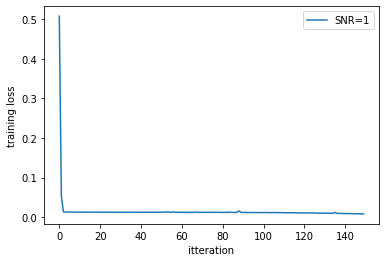

In [ ]:
# print(history.)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='SNR=1')
plt.xlabel('itteration')
plt.ylabel('training loss')
plt.legend()